<a href="https://colab.research.google.com/github/jumadi-cloud/classification_capsule_network/blob/main/Classification_PapSmear_Cervical_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/mohaliy2016/project-001-image-classification-from-scratch

In [1]:
import os
import itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
!pip install gdown

In [3]:
import gdown

file_id = "1OvXi_vnrqTShJylSYR0YT-PiOcGvErZ2"  # Replace this with your file's ID
output_file = "Pap Smear Cervical Cancer.zip"  # Replace "data_file.ext" with the desired output filename and extension

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1OvXi_vnrqTShJylSYR0YT-PiOcGvErZ2
To: /content/Pap Smear Cervical Cancer.zip
100%|██████████| 6.15G/6.15G [01:17<00:00, 79.3MB/s]


'Pap Smear Cervical Cancer.zip'

In [4]:
import zipfile
with zipfile.ZipFile("/content/Pap Smear Cervical Cancer.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [5]:
num_classes = 4 # the image dataset has five classes.
input_shape = (128, 128)
batch_size = 32

CLASS = ["H-Sil","L-Sil", "Sel Koilocyt","Sel Normal"]

In [6]:
topDir = '/content/Pap Smear Cervical Cancer/CervicalCancer8020'
os.chdir(topDir)
TnVDir = os.path.join(topDir,'/content/Pap Smear Cervical Cancer/CervicalCancer8020/train')
TestDir = os.path.join(topDir,'/content/Pap Smear Cervical Cancer/CervicalCancer8020/valid')

In [7]:
train_datagen = ImageDataGenerator(
    validation_split=0.2,
)
test_datagen = ImageDataGenerator(
     #rescale=1./255,
)

Train_Generator = train_datagen.flow_from_directory(
    TnVDir,
    target_size = input_shape,
    batch_size = batch_size,
    shuffle =True,
    class_mode = 'categorical',
    subset = 'training'
)
Validation_Generator = train_datagen.flow_from_directory(
    TnVDir,
    target_size = input_shape,
    batch_size = batch_size,
    shuffle =True,
    class_mode = 'categorical',
    subset = 'validation'
)
Test_Generator = test_datagen.flow_from_directory(
    TestDir,
    target_size = input_shape,
    batch_size = 500,
    class_mode = 'categorical',
)

Found 7902 images belonging to 4 classes.
Found 1973 images belonging to 4 classes.
Found 2280 images belonging to 4 classes.


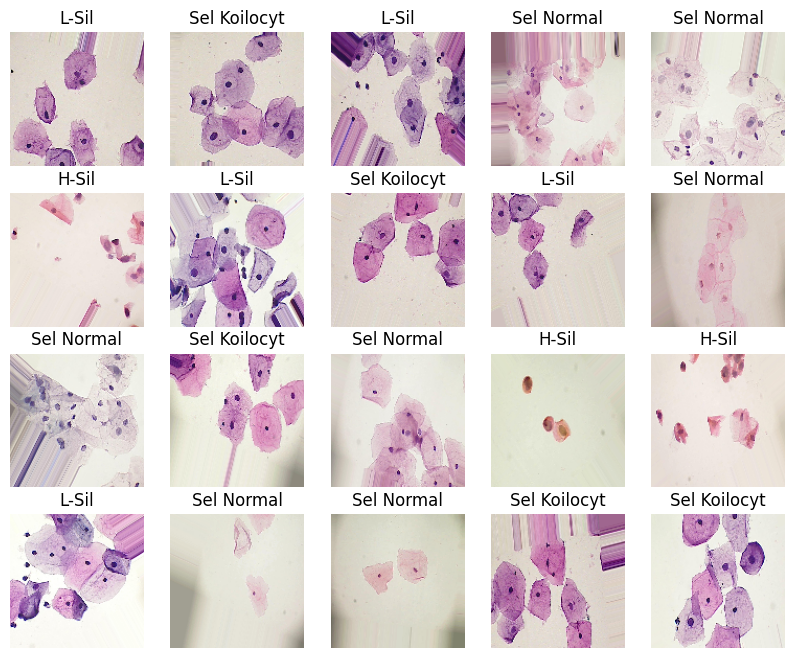

In [8]:
import matplotlib.pyplot as plt
Train_imgs, Train_labels = next(Train_Generator)
plt.figure(figsize=(10,8))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(Train_imgs[i].astype("uint8"))
    plt.title(CLASS[int(np.where(Train_labels==1)[1][i])])
    plt.axis("off")

In [9]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

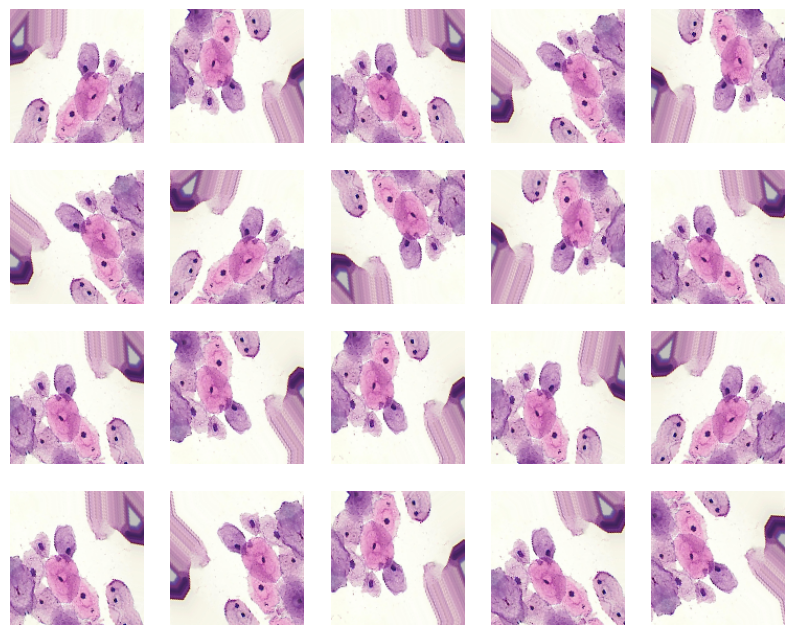

In [10]:
plt.figure(figsize=(10, 8))
Train_imgs, _ = next(Train_Generator)
for i in range(20):
    augmented_images = data_augmentation(Train_imgs)
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

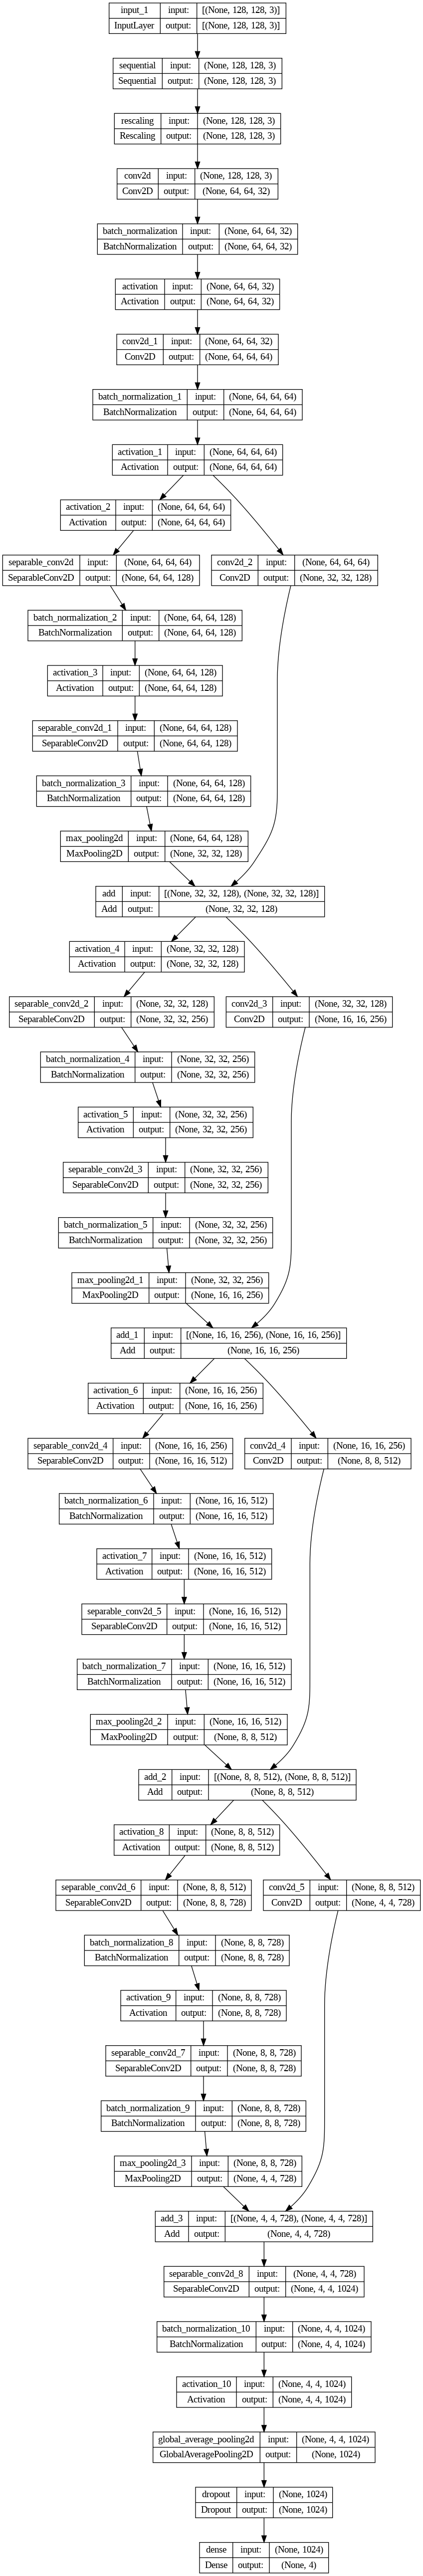

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=input_shape + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [12]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("working/save_at_{epoch}.h5"),]

model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    Train_Generator, epochs=epochs, callbacks=callbacks, validation_data=Validation_Generator,
)


Epoch 1/50
247/247 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.7914

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


247/247 [==============================] - 286s 1s/step - loss: 0.4958 - accuracy: 0.7914 - val_loss: 2.4304 - val_accuracy: 0.2408
Epoch 2/50
247/247 [==============================] - 252s 1s/step - loss: 0.3299 - accuracy: 0.8548 - val_loss: 2.9165 - val_accuracy: 0.3847
Epoch 3/50
247/247 [==============================] - 249s 1s/step - loss: 0.2911 - accuracy: 0.8657 - val_loss: 1.2578 - val_accuracy: 0.5940
Epoch 4/50
247/247 [==============================] - 254s 1s/step - loss: 0.2896 - accuracy: 0.8702 - val_loss: 1.2835 - val_accuracy: 0.5758
Epoch 5/50
247/247 [==============================] - 249s 1s/step - loss: 0.2662 - accuracy: 0.8767 - val_loss: 3.1602 - val_accuracy: 0.4526
Epoch 6/50
247/247 [==============================] - 277s 1s/step - loss: 0.2652 - accuracy: 0.8824 - val_loss: 7.0134 - val_accuracy: 0.4141
Epoch 7/50
247/247 [==============================] - 255s 1s/step - loss: 0.2577 - accuracy: 0.8823 - val_loss: 0.4061 - val_accuracy: 0.8125
Epoch 8/50

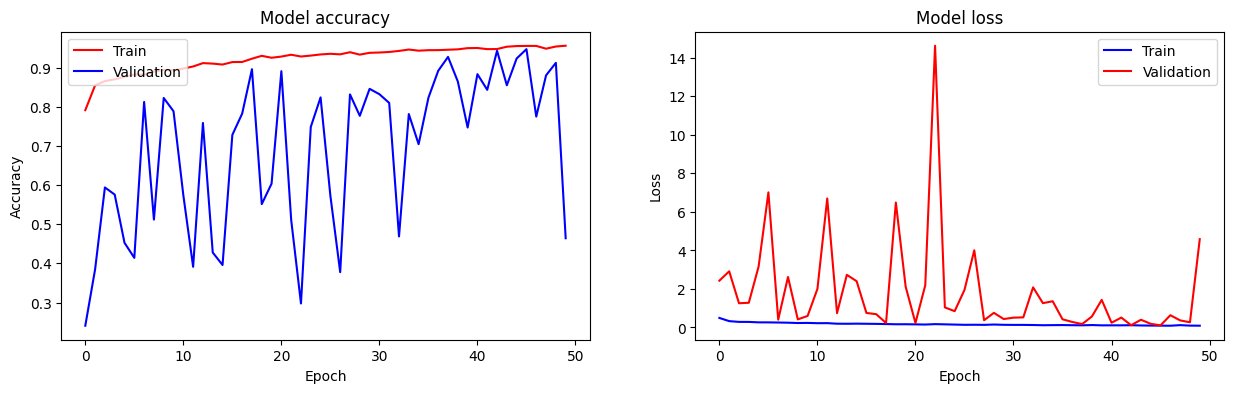

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],color='b')
plt.plot(history.history['val_loss'],color='r')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')

In [18]:
im = keras.preprocessing.image.load_img(
    "/content/Pap Smear Cervical Cancer/CervicalCancer801010/test/H-Sil/h-sil_0_8118.jpg", target_size=input_shape
)  #Change directory if you want to experiment with different test images.
img_array = keras.preprocessing.image.img_to_array(im)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array = img_array
prediction = model.predict(img_array)
prediction = prediction[0]
print(
    "This image is %.2f percent H-Sil, %.2f percent L-Sil, %.2f percent Sel Koilocyt and %.2f percent Sel Normal."
    % (100 * prediction[0],100 * prediction[1],100 * prediction[2],100 * prediction[3] )
)

1/1 [==============================] - 0s 18ms/step
This image is 100.00 percent H-Sil, 0.00 percent L-Sil, 0.00 percent Sel Koilocyt and 0.00 percent Sel Normal.


In [15]:
labels = np.argsort(prediction)
labels = labels[::-1]
scores = np.sort(prediction)
scores = scores[::-1]
for i in range(len(prediction)):
    print(i+1,'. ',CLASS[labels[i]], ':', round(scores[i]*100,3),"%")

1 .  H-Sil : 100.0 %
2 .  Sel Koilocyt : 0.0 %
3 .  L-Sil : 0.0 %
4 .  Sel Normal : 0.0 %


In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=-45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

5/5 [==============================] - 73s 13s/step - loss: 4.3831 - accuracy: 0.4838

Average test accuracy:  48.37719202041626


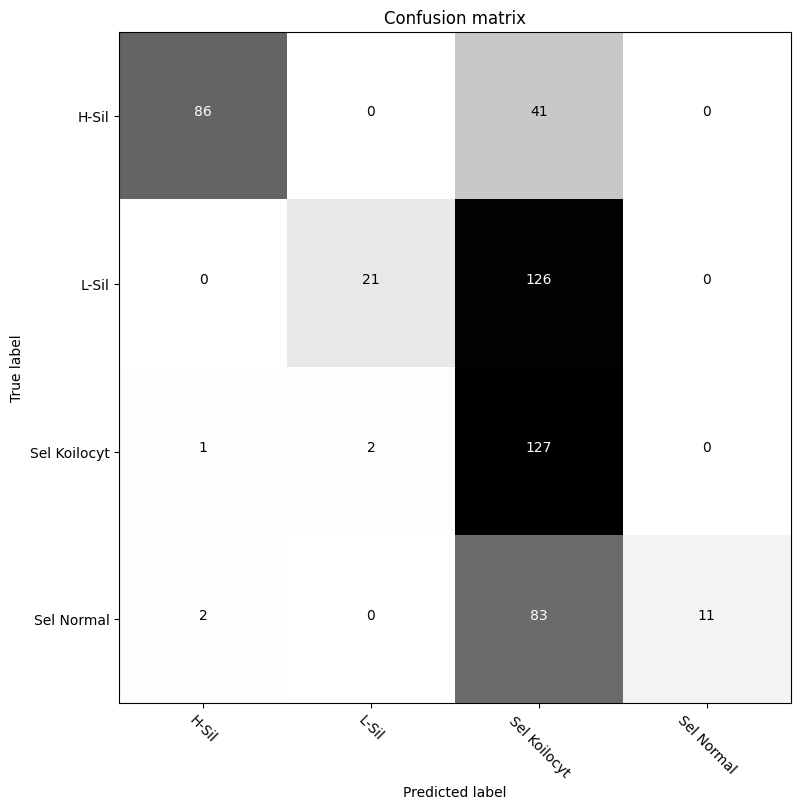

In [17]:
Test_imgs, Test_labels = next(Test_Generator)
Prediction = model.predict(Test_imgs)
Predicted_Classes = np.argmax(Prediction,axis=1)
True_Classes = np.argmax(Test_labels,axis=1)
confusion_mtx = confusion_matrix(True_Classes, Predicted_Classes)
plot_confusion_matrix(confusion_mtx, classes = list(CLASS))
Score, Acc = model.evaluate(Test_Generator,verbose=1)
print("\nAverage test accuracy: ",Acc*100);